# Computer Visions Jupyter Notebook

# Allie Garrison


In [1]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
conn = sqlite3.connect('zippedData/im.db')

bom_movie_gross = pd.read_csv("zippedData/bom.movie_gross.csv")
rt_movie_info = pd.read_csv("zippedData/rt.movie_info.tsv", sep='\t')
rt_reviews = pd.read_csv('zippedData/rt.reviews.tsv', sep='\t',encoding='windows-1252')
tmdb_movies = pd.read_csv("zippedData/tmdb.movies.csv")
tn_movie_budgets = pd.read_csv("zippedData/tn.movie_budgets.csv", parse_dates=['release_date'])

In [3]:
## Making copy of movie budgets data frame for cleaning
tn_movie_budgets_clean = tn_movie_budgets.copy()

## turning the columns with dollar amounts into int types in millions of dollars
tn_movie_budgets_clean['production_budget_in_millions'] = tn_movie_budgets_clean['production_budget'].str.strip('$').str.replace(',', '')
tn_movie_budgets_clean['production_budget_in_millions'] = tn_movie_budgets_clean['production_budget_in_millions'].astype('int64') / 1000000

tn_movie_budgets_clean['domestic_gross_in_millions'] = tn_movie_budgets_clean['domestic_gross'].str.strip('$').str.replace(',', '')
tn_movie_budgets_clean['domestic_gross_in_millions'] = tn_movie_budgets_clean['domestic_gross_in_millions'].astype('int64') / 1000000

tn_movie_budgets_clean['worldwide_gross_in_millions'] = tn_movie_budgets_clean['worldwide_gross'].str.strip('$').str.replace(',', '')
tn_movie_budgets_clean['worldwide_gross_in_millions'] = tn_movie_budgets_clean['worldwide_gross_in_millions'].astype('int64') / 1000000

## taking out all movies that were released before January 1, 2010
tn_movie_budgets_clean = tn_movie_budgets_clean[tn_movie_budgets_clean['release_date'] >= "2010-01-01"]

## taking out all movies that did not make a profit
tn_movie_budgets_clean = tn_movie_budgets_clean[tn_movie_budgets_clean['domestic_gross_in_millions'] != 0]

In [4]:
## Creating columns with return on investment (ROI) for domestic and international revenue
tn_movie_budgets_clean['ROI_domestic'] = (tn_movie_budgets_clean['domestic_gross_in_millions'] / tn_movie_budgets_clean['production_budget_in_millions']) * 100
tn_movie_budgets_clean['ROI_international'] = (tn_movie_budgets_clean['worldwide_gross_in_millions'] / tn_movie_budgets_clean['production_budget_in_millions']) * 100

### 

In [5]:
## joining movie_basics and movie_ratings to create a data frame with title, runtime, genre, ratings, and votes
table_genre = pd.read_sql('''
SELECT mb.primary_title, 
        mb.runtime_minutes, 
        mb.genres, 
        mr.averagerating,
        mr.numvotes,
        mb.runtime_minutes
FROM movie_basics AS mb
JOIN movie_ratings AS mr USING (movie_id)
''', conn)

In [6]:
## merging the cleaned tn.movie_budgets dataframe with table_genre on movie title
genre_ratings_budget = tn_movie_budgets_clean.merge(table_genre, how='inner', left_on='movie', right_on='primary_title')

In [7]:
genre_ratings_budget.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,production_budget_in_millions,domestic_gross_in_millions,worldwide_gross_in_millions,ROI_domestic,ROI_international,primary_title,runtime_minutes,genres,averagerating,numvotes,runtime_minutes
0,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875",410.6,241.063875,1045.663875,58.710150,254.667286,Pirates of the Caribbean: On Stranger Tides,136.0,"Action,Adventure,Fantasy",6.6,447624,136.0
1,3,2019-06-07,Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350",350.0,42.762350,149.762350,12.217814,42.789243,Dark Phoenix,113.0,"Action,Adventure,Sci-Fi",6.0,24451,113.0
2,4,2015-05-01,Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963",330.6,459.005868,1403.013963,138.840250,424.384139,Avengers: Age of Ultron,141.0,"Action,Adventure,Sci-Fi",7.3,665594,141.0
3,7,2018-04-27,Avengers: Infinity War,"$300,000,000","$678,815,482","$2,048,134,200",300.0,678.815482,2048.134200,226.271827,682.711400,Avengers: Infinity War,149.0,"Action,Adventure,Sci-Fi",8.5,670926,149.0
4,9,2017-11-17,Justice League,"$300,000,000","$229,024,295","$655,945,209",300.0,229.024295,655.945209,76.341432,218.648403,Justice League,120.0,"Action,Adventure,Fantasy",6.5,329135,120.0


# Cole Sussmeier

In [8]:
# create profit column
genre_ratings_budget['profit_in_millions'] = genre_ratings_budget['worldwide_gross_in_millions'] - genre_ratings_budget['production_budget_in_millions']

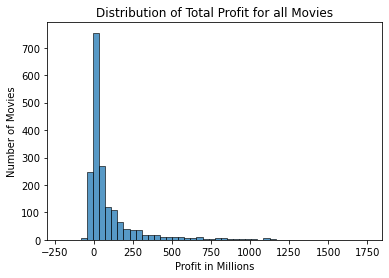

In [9]:
plt.title("Distribution of Total Profit for all Movies")
plt.xlabel("Profit in Millions")
plt.ylabel("Number of Movies")
sns.histplot(genre_ratings_budget['profit_in_millions'], bins=50);

### Get average values for features by genre

In [10]:
# genre_hash is a dictionary where each key is a genre, and the value is the number of times it occurs in the 'genres' column
genre_hash = {}

# array of lists where each individual list is every genre listed for a single movie
genre_lists = genre_ratings_budget['genres'].str.split(',')

for i, genres in enumerate(genre_lists):
    # try/ except in case there is an empty list (no genres listed for a movie)
    try:
        for genre in genres:
            # add one to genre if the key exists
            if genre in genre_hash.keys():
                genre_hash[genre] += 1
            # otherwise create the key
            else:
                genre_hash[genre] = 1
    except:
        pass


In [11]:
genre_hash

{'Action': 466,
 'Adventure': 365,
 'Fantasy': 135,
 'Sci-Fi': 146,
 'Thriller': 314,
 'Western': 12,
 'Animation': 105,
 'Comedy': 558,
 'Family': 95,
 'Crime': 258,
 'Drama': 953,
 'Musical': 11,
 'Horror': 207,
 'Romance': 227,
 'Mystery': 144,
 'Documentary': 91,
 'Biography': 155,
 'History': 59,
 'Sport': 43,
 'War': 26,
 'Music': 57,
 'News': 2}

In [12]:
genre_stats = []
for genre in genre_hash.keys():
    #filter for every entry that contains the current genre
    mask = genre_ratings_budget[genre_ratings_budget['genres'].str.contains(genre) == True]
    # append list with averages for relevant features
    genre_stats.append([genre, mask['profit_in_millions'].mean().round(2), 
                        mask['production_budget_in_millions'].mean().round(2),
                        mask['averagerating'].mean().round(2),
                        mask['numvotes'].mean().round(2)])

In [13]:
#convert to dataframe
genre_stats_df = pd.DataFrame(genre_stats, 
                              columns=['Genre', 'Average_Profit', 'Average_Budget', 'Average_Rating', 'Average_Votes'])
genre_stats_df

,Genre,Average_Profit,Average_Budget,Average_Rating,Average_Votes
0,Action,160.90,79.93,6.33,173279.07
1,Adventure,241.02,105.76,6.49,195600.38
2,Fantasy,165.87,82.88,6.11,137905.34
3,Sci-Fi,236.87,88.97,6.49,258160.36
4,Thriller,82.10,34.26,6.05,105111.21
5,Western,46.35,50.07,6.78,165738.00
6,Animation,280.62,98.50,6.67,121386.85
7,Comedy,92.29,39.56,6.29,88686.08
8,Family,141.12,70.00,6.17,76245.96
9,Crime,50.29,32.38,6.39,106000.05


In [14]:
# important note: There are many instances where genres overlap, ie Avengers Endgame is action and adventure.
# This means that the profit of this individual movie is factored into the averages for both genres 
# and they are not independent measures

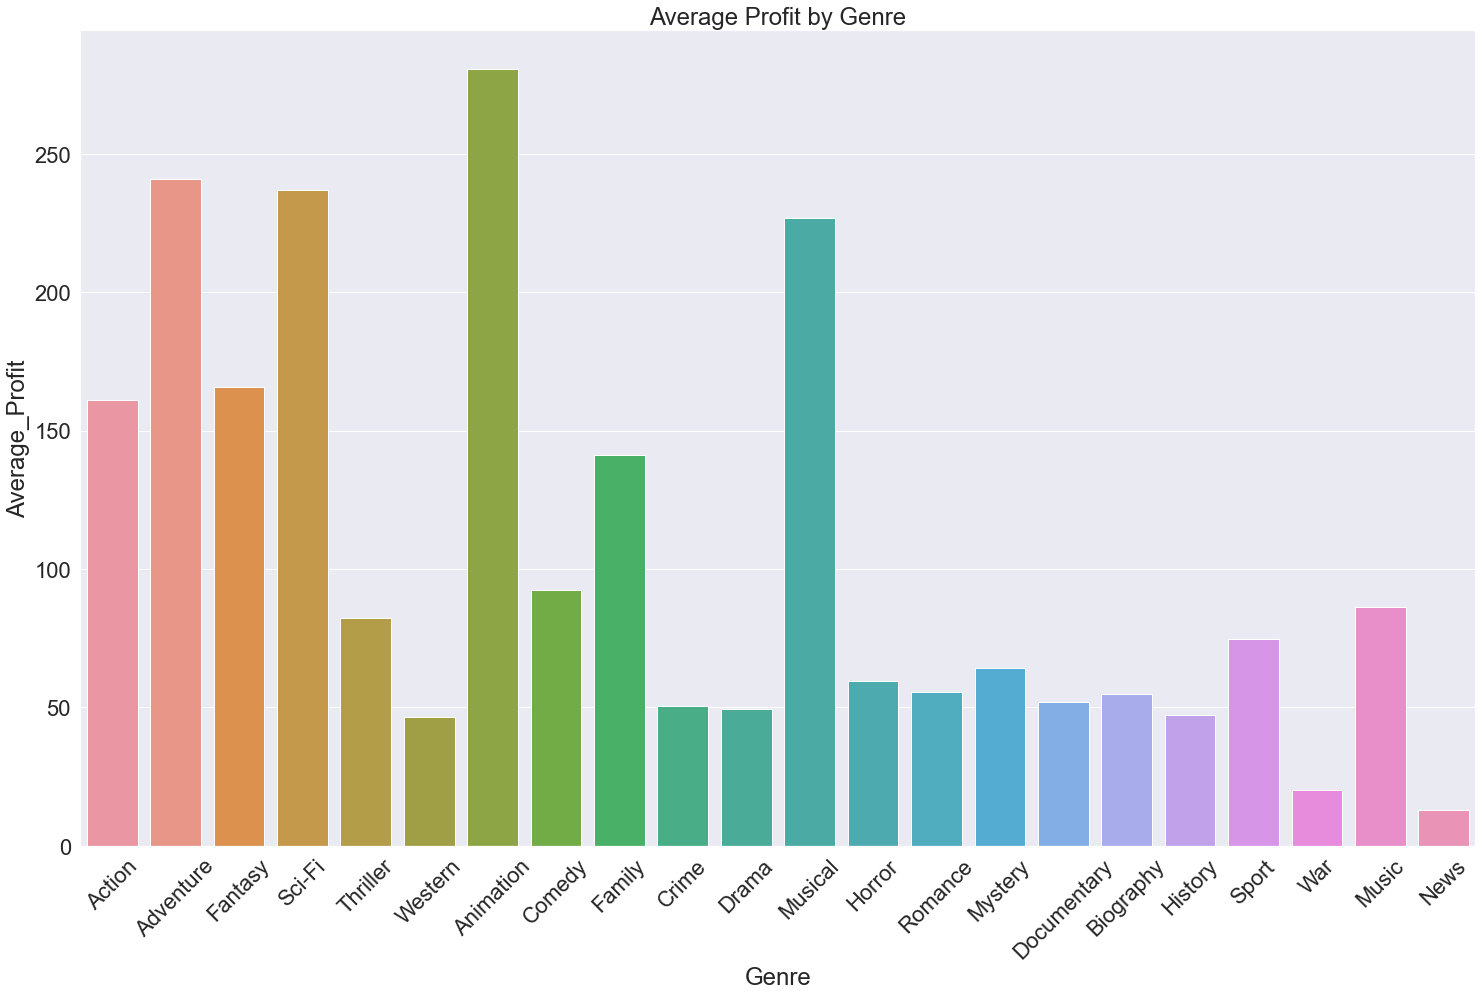

In [15]:
plt.figure(figsize=(25,15))
sns.set(font_scale=2)
plt.xticks(rotation=45)
plt.title("Average Profit by Genre")
sns.barplot(data = genre_stats_df, x='Genre', y='Average_Profit');


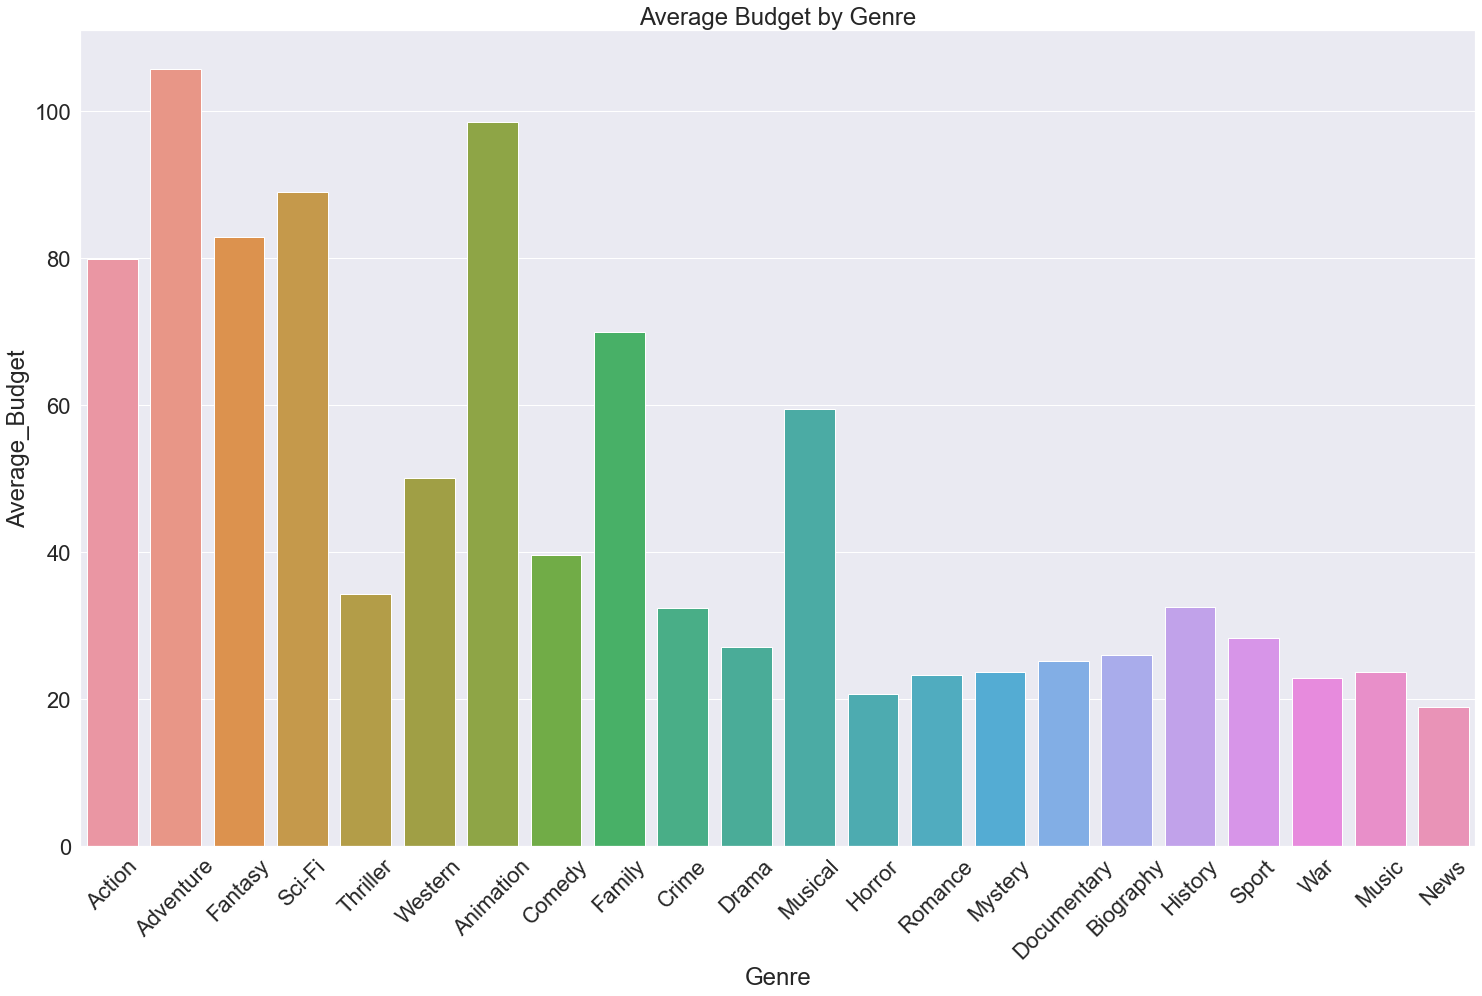

In [16]:
plt.figure(figsize=(25,15))
plt.xticks(rotation=45)
plt.title("Average Budget by Genre")
sns.barplot(data = genre_stats_df, x='Genre', y='Average_Budget');

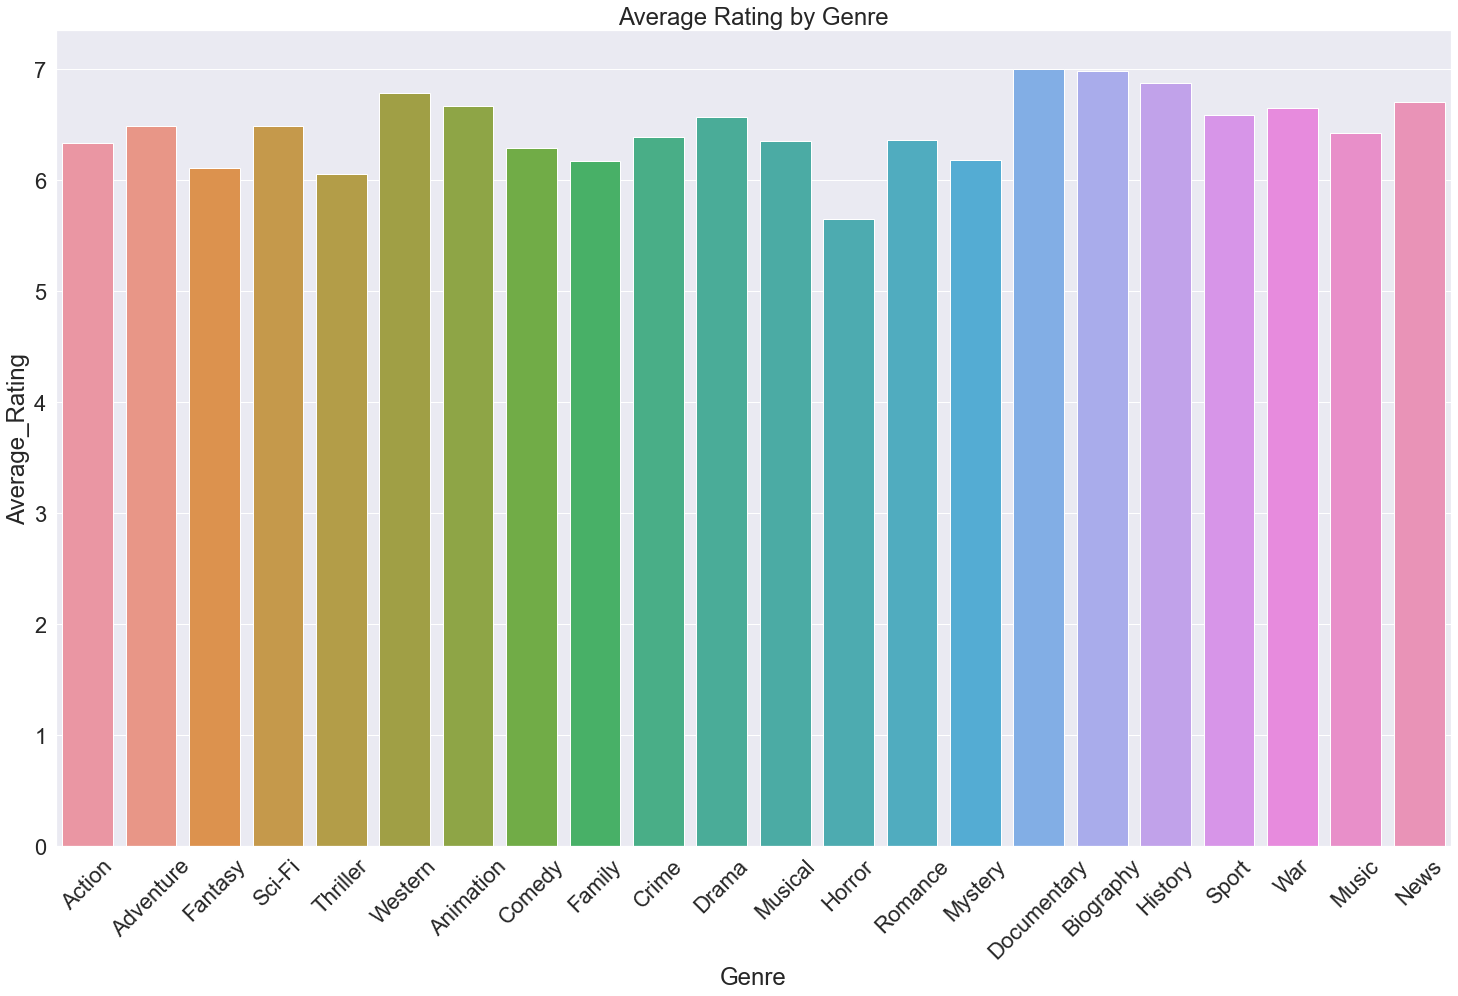

In [17]:
plt.figure(figsize=(25,15))
plt.xticks(rotation=45)
plt.title("Average Rating by Genre")
sns.barplot(data = genre_stats_df, x='Genre', y='Average_Rating');

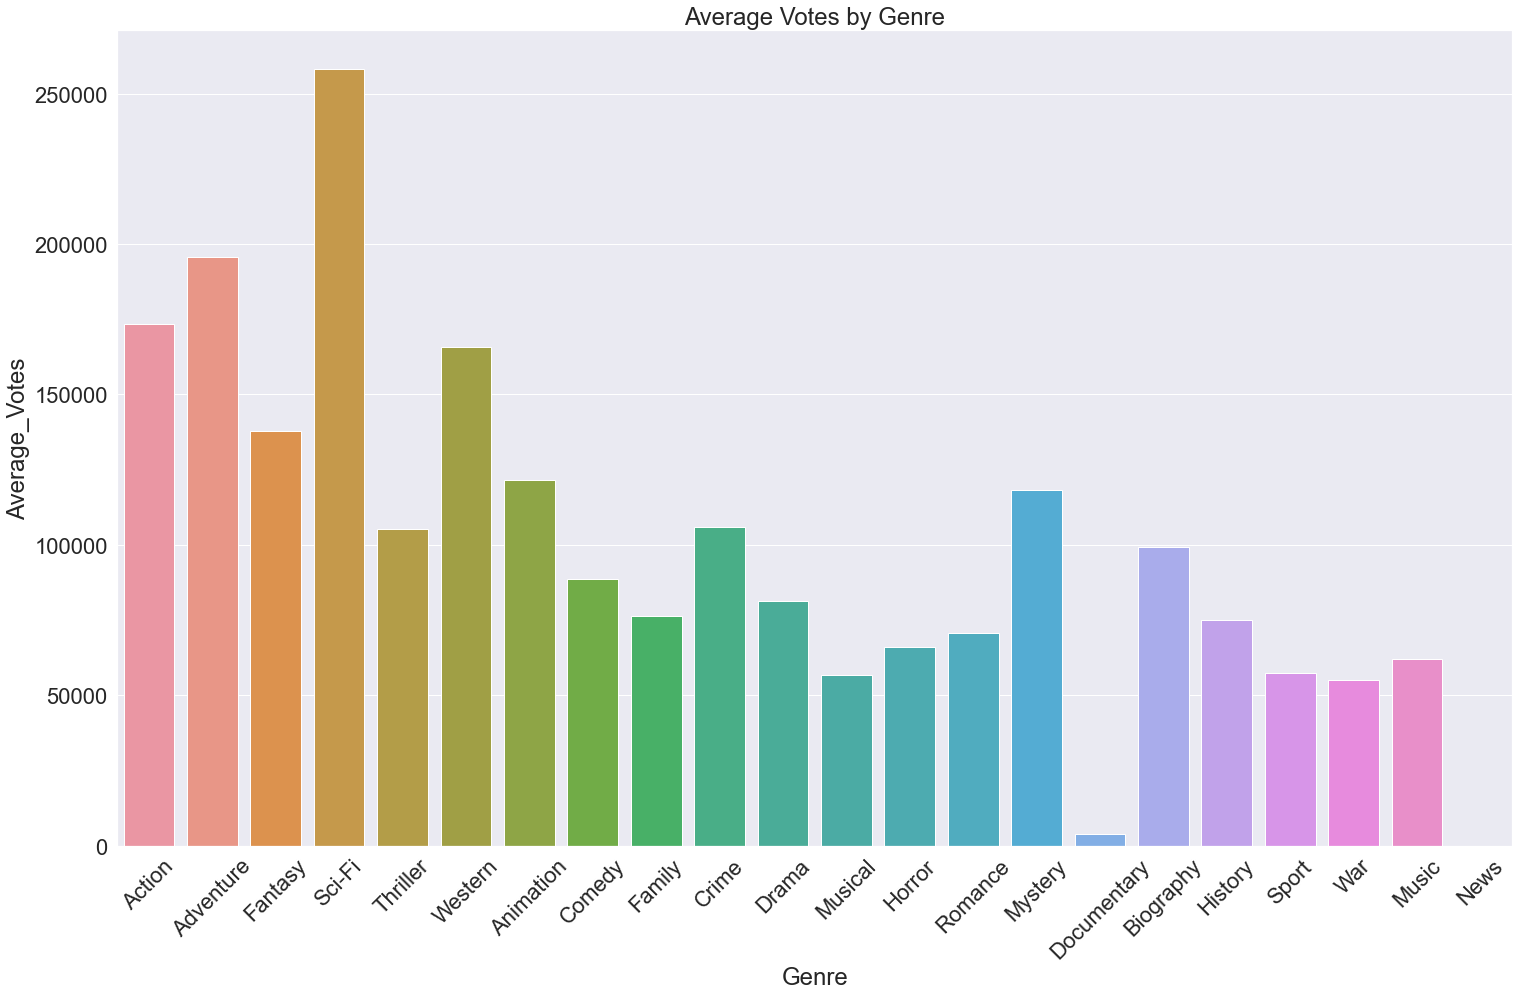

In [18]:
plt.figure(figsize=(25,15))
plt.xticks(rotation=45)
plt.title("Average Votes by Genre")
sns.barplot(data = genre_stats_df, x='Genre', y='Average_Votes');

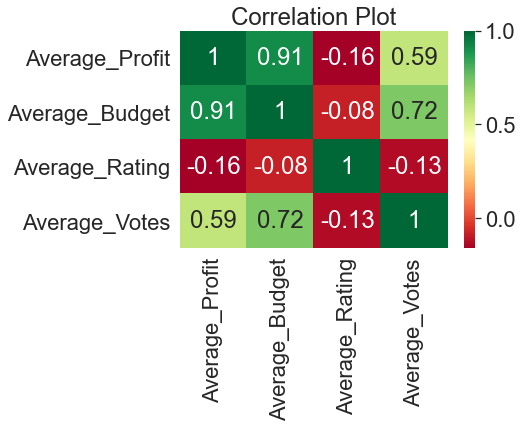

In [19]:
plt.title("Correlation Plot")
sns.heatmap(genre_stats_df.corr().round(2), cmap="RdYlGn", annot=True);

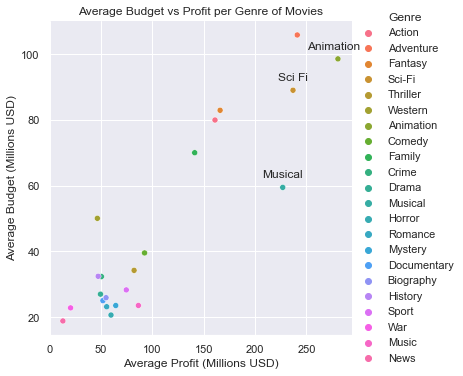

### Correlation plot for animation movies

In [21]:
animation = genre_ratings_budget[genre_ratings_budget['genres'].str.contains('Animation') == True]

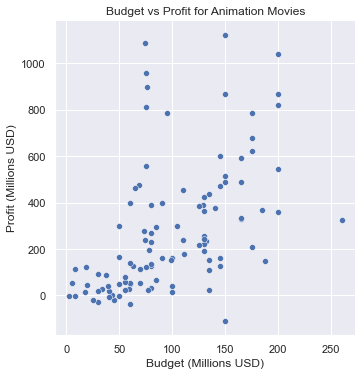

In [28]:
sns.set(font_scale=1)
sns.relplot(data=animation, 
            x ="production_budget_in_millions", y="profit_in_millions")
plt.xlabel("Budget (Millions USD)")
plt.ylabel("Profit (Millions USD)")
plt.title("Budget vs Profit for Animation Movies");

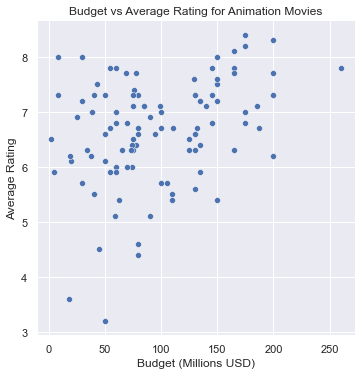

In [33]:
sns.set(font_scale=1)
sns.relplot(data=animation, 
            x ="production_budget_in_millions", y="averagerating")
plt.xlabel("Budget (Millions USD)")
plt.ylabel("Average Rating")
plt.title("Budget vs Average Rating for Animation Movies");

In [32]:
# top ten most profitable
animation.sort_values('profit_in_millions', ascending=False).head(10)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,production_budget_in_millions,domestic_gross_in_millions,worldwide_gross_in_millions,ROI_domestic,ROI_international,primary_title,runtime_minutes,genres,averagerating,numvotes,runtime_minutes,profit_in_millions
126,56,2013-11-22,Frozen,"$150,000,000","$400,738,009","$1,272,469,910",150.0,400.738009,1272.469910,267.158673,848.313273,Frozen,102.0,"Adventure,Animation,Comedy",7.5,516998,102.0,1122.469910
344,73,2015-07-10,Minions,"$74,000,000","$336,045,770","$1,160,336,173",74.0,336.045770,1160.336173,454.115905,1568.021855,Minions,91.0,"Adventure,Animation,Comedy",6.4,193917,91.0,1086.336173
35,44,2018-06-15,Incredibles 2,"$200,000,000","$608,581,744","$1,242,520,711",200.0,608.581744,1242.520711,304.290872,621.260355,Incredibles 2,118.0,"Action,Adventure,Animation",7.7,203510,118.0,1042.520711
332,30,2017-06-30,Despicable Me 3,"$75,000,000","$264,624,300","$1,034,727,750",75.0,264.624300,1034.727750,352.832400,1379.637000,Despicable Me 3,89.0,"Adventure,Animation,Comedy",6.3,92580,89.0,959.727750
329,22,2013-07-03,Despicable Me 2,"$76,000,000","$368,065,385","$975,216,835",76.0,368.065385,975.216835,484.296559,1283.180046,Despicable Me 2,98.0,"Adventure,Animation,Comedy",7.4,344230,98.0,899.216835
127,57,2016-03-04,Zootopia,"$150,000,000","$341,268,248","$1,019,429,616",150.0,341.268248,1019.429616,227.512165,679.619744,Zootopia,108.0,"Adventure,Animation,Comedy",8.0,383446,108.0,869.429616
38,47,2010-06-18,Toy Story 3,"$200,000,000","$415,004,880","$1,068,879,522",200.0,415.004880,1068.879522,207.502440,534.439761,Toy Story 3,103.0,"Adventure,Animation,Comedy",8.3,682218,103.0,868.879522
37,46,2016-06-17,Finding Dory,"$200,000,000","$486,295,561","$1,021,215,193",200.0,486.295561,1021.215193,243.147781,510.607596,Finding Dory,97.0,"Adventure,Animation,Comedy",7.3,213542,97.0,821.215193
330,26,2016-07-08,The Secret Life of Pets,"$75,000,000","$368,384,330","$886,750,534",75.0,368.384330,886.750534,491.179107,1182.334045,The Secret Life of Pets,87.0,"Adventure,Animation,Comedy",6.5,161997,87.0,811.750534
76,97,2016-04-15,The Jungle Book,"$175,000,000","$364,001,123","$962,854,547",175.0,364.001123,962.854547,208.000642,550.202598,The Jungle Book,64.0,Animation,7.0,59,64.0,787.854547


In [34]:
# top ten animated movies by rating
animation.sort_values('averagerating', ascending=False).head(10)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,production_budget_in_millions,domestic_gross_in_millions,worldwide_gross_in_millions,ROI_domestic,ROI_international,primary_title,runtime_minutes,genres,averagerating,numvotes,runtime_minutes,profit_in_millions
84,2,2017-11-22,Coco,"$175,000,000","$209,726,015","$798,008,101",175.0,209.726015,798.008101,119.843437,456.004629,Coco,105.0,"Adventure,Animation,Comedy",8.4,277194,105.0,623.008101
38,47,2010-06-18,Toy Story 3,"$200,000,000","$415,004,880","$1,068,879,522",200.0,415.004880,1068.879522,207.502440,534.439761,Toy Story 3,103.0,"Adventure,Animation,Comedy",8.3,682218,103.0,868.879522
80,98,2015-06-19,Inside Out,"$175,000,000","$356,461,711","$854,235,992",175.0,356.461711,854.235992,203.692406,488.134853,Inside Out,95.0,"Adventure,Animation,Comedy",8.2,536181,95.0,679.235992
104,30,2010-03-26,How to Train Your Dragon,"$165,000,000","$217,581,232","$494,870,992",165.0,217.581232,494.870992,131.867413,299.921813,How to Train Your Dragon,98.0,"Action,Adventure,Animation",8.1,611299,98.0,329.870992
1391,36,2019-01-16,Dragon Ball Super: Broly,"$8,500,000","$30,376,755","$122,747,755",8.5,30.376755,122.747755,357.373588,1444.091235,Dragon Ball Super: Broly,100.0,"Action,Adventure,Animation",8.0,16465,100.0,114.247755
795,100,2018-02-02,Bilal: A New Breed of Hero,"$30,000,000","$490,973","$648,599",30.0,0.490973,0.648599,1.636577,2.161997,Bilal: A New Breed of Hero,105.0,"Action,Adventure,Animation",8.0,16854,105.0,-29.351401
127,57,2016-03-04,Zootopia,"$150,000,000","$341,268,248","$1,019,429,616",150.0,341.268248,1019.429616,227.512165,679.619744,Zootopia,108.0,"Adventure,Animation,Comedy",8.0,383446,108.0,869.429616
10,15,2010-11-24,Tangled,"$260,000,000","$200,821,936","$586,477,240",260.0,200.821936,586.477240,77.239206,225.568169,Tangled,100.0,"Adventure,Animation,Comedy",7.8,366366,100.0,326.477240
145,99,2014-06-13,How to Train Your Dragon 2,"$145,000,000","$177,002,924","$614,586,270",145.0,177.002924,614.586270,122.070982,423.852600,How to Train Your Dragon 2,102.0,"Action,Adventure,Animation",7.8,278205,102.0,469.586270
103,29,2014-11-07,Big Hero 6,"$165,000,000","$222,527,828","$652,127,828",165.0,222.527828,652.127828,134.865350,395.228987,Big Hero 6,102.0,"Action,Adventure,Animation",7.8,371204,102.0,487.127828


In [21]:
# feel free to run any statistical tests that may be relevant to our reccomendations... this is just the outline required
# for a 1sample t-test

In [22]:
avg_profit = genre_ratings_budget['profit_in_millions'].mean()
print(avg_profit)

94.15790165165491


In [23]:
action = genre_ratings_budget[genre_ratings_budget['genres'].str.contains('Action') == True]

In [24]:
from scipy import stats

In [25]:
stats.ttest_1samp(action['profit_in_millions'], popmean=avg_profit)

Ttest_1sampResult(statistic=5.621600148484867, pvalue=3.2669437136587626e-08)

In [26]:
# avg profit from action is significantly different than avg profit overall

## Working Area 1- Jacob and Matt

In [ ]:
conn = sqlite3.connect("im.db")



pd.read_sql("""
SELECT *



FROM movie_rating



""",conn)

In [ ]:
conn = sqlite3.connect("im.db")



pd.read_sql("""
SELECT *



FROM principals



""",conn)
#checking principals for insights between actors and revenue

In [ ]:
conn = sqlite3.connect("im.db")



pd.read_sql("""
SELECT *



FROM directors



""",conn)
#checking directors to correlate to movie and then to revenue

In [ ]:
conn = sqlite3.connect("im.db")



pd.read_sql("""
SELECT *



FROM movie_basics



""",conn)
#exploring how to match movie id to title and then match that to revenue in other dataset

In [ ]:
#Querying to find the runtime of the top 10 animation movies by rating 
df_runtime_raw = pd.read_sql('''
SELECT 
    primary_title as "Movie", runtime_minutes as "Run Time"
FROM 
    movie_basics as mb
JOIN
    movie_ratings USING (movie_id)
where 
    genres like "%Animation%"
    and  "Run Time" < 200
AND 
    runtime_minutes != "Nan"
ORDER BY
    averagerating DESC
LIMIT 10


''', conn)

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.barplot(data = df_runtime_raw, x='Movie', y='Run Time')
plt.xlabel("Movie")
plt.ylabel("Run Time")
plt.title("Animation Movies Run Time")
plt.xticks(rotation = 45)
#plotting our movies from above

<h2> Working Area 2 - Cameron Narimanian

<h3> Number of Films Per Genre Since 2010

In [ ]:
genre_stats_df

In [ ]:
sns.set(font_scale=1)
sns.relplot(data=genre_stats_df, 
            x ="Average_Profit", y="Average_Budget",
            hue = "Genre")
scifi = genre_stats_df[genre_stats_df['Genre'] == 'Sci-Fi']
animation = genre_stats_df[genre_stats_df['Genre'] == 'Animation']
musical = genre_stats_df[genre_stats_df['Genre'] == 'Musical']
plt.text(scifi['Average_Profit']-15, scifi['Average_Budget']+3, 'Sci Fi')
plt.text(animation['Average_Profit']-30, animation['Average_Budget']+3, 'Animation')
plt.text(musical['Average_Profit']-20, musical['Average_Budget']+3, 'Musical')

plt.xlabel("Average Profit (Millions USD)")
plt.ylabel("Average Budget (Millions USD)")
plt.title("Average Budget vs Profit per Genre of Movies");

## Working Area 3